# Imports

In [194]:
# General processing libraries

import pandas as pd
import numpy as np

# Plotting libraries

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

# Preprocessing and pre-modelling data manipulation

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split

# Regression models

from sklearn.linear_model import ElasticNetCV

# Classification models

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import BernoulliNB, MultinomialNB

from sklearn.svm import SVC

from xgboost import XGBClassifier

# Model assessment

from sklearn.metrics import classification_report, confusion_matrix

In [7]:
original_articles = pd.read_csv('combined_articles.csv')
original_comments = pd.read_csv('combined_comments.csv')

D:\Utilities\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [129]:
articles = original_articles.copy()
comments = original_comments.copy()

comments = comments[comments['depth'] == 1]
comments.drop(['Unnamed: 0', 'articleWordCount', 'commentID', 'commentType', 'inReplyTo', 'editorsSelection', 'sharing', 'timespeople', 'trusted', 'userID', 'approvalInterval', 'replyCount', 'userLocation', 'parentID', 'parentUserDisplayName', 'permID', 'picURL', 'sectionName', 'userDisplayName', 'updateDate', 'depth', 'printPage'], axis = 1, inplace = True)

comments['approveDate'] = comments['approveDate'].astype('datetime64[ns]')
comments = comments.merge(articles[['articleID', 'pubDate']], on ='articleID')
comments['pubDate'] = comments['pubDate'].astype('datetime64[ns]')
comments['age'] = (comments['pubDate'] - comments['approveDate']).dt.seconds

comments['approveMinuteByDay'] = comments['approveDate'].dt.hour * 60 + comments['approveDate'].dt.minute
comments['approveHourByMonth'] = (comments['approveDate'].dt.day - 1) * 24 + comments['approveDate'].dt.hour
comments['approveMinuteByMonth'] = (comments['approveDate'].dt.day - 1) * 24 * 60 + comments['approveDate'].dt.hour * 60 + comments['approveDate'].dt.minute
comments['approveHour'] = comments['approveDate'].dt.hour
comments['approveDay'] = comments['approveDate'].dt.day

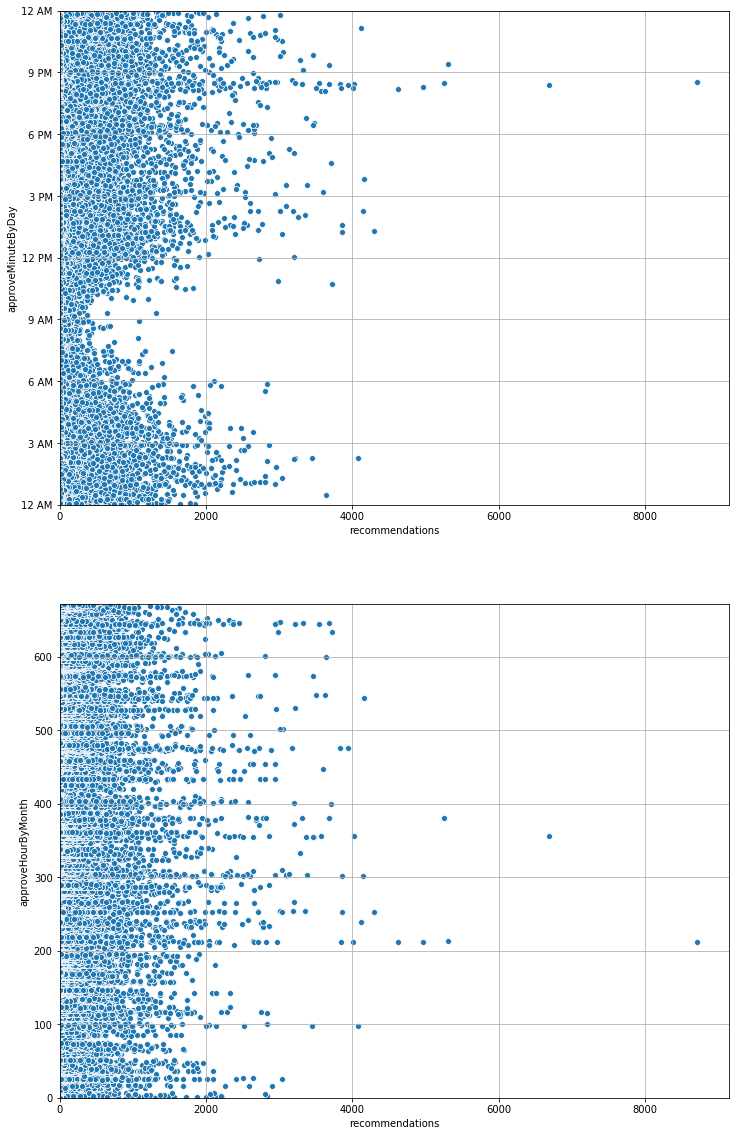

In [130]:
fig, axes = plt.subplots(2, 1, figsize = (12, 20))
ax1, ax2 = axes
sns.scatterplot(y = 'approveMinuteByDay', x = 'recommendations', data = comments, palette = 'Blues_r', ax = ax1)
ax1.set_yticks(np.linspace(0, 1440, 9, endpoint = True))
ax1.set_yticklabels(['12 AM', '3 AM', '6 AM', '9 AM', '12 PM', '3 PM', '6 PM', '9 PM', '12 AM'])
ax1.axis(xmin = 0, ymin = 0, ymax = 24 * 60)
ax1.grid(True)
sns.scatterplot(y = 'approveHourByMonth', x = 'recommendations', data = comments[comments['approveDay'] <= 28], palette = 'Blues_r', ax = ax2)
ax2.axis(xmin = 0, ymin = 0, ymax = 28 * 24)
ax2.grid(True)

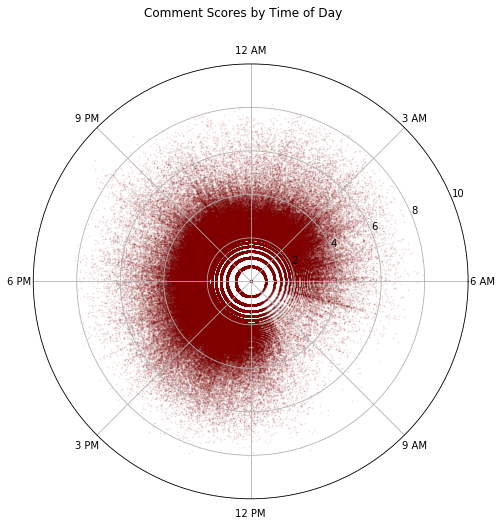

In [121]:
plotting_df = comments.copy()
plotting_df['approveMinuteByDay'] = plotting_df['approveMinuteByDay'] * -2 * np.pi / (24 * 60) + 0.5 * np.pi
plotting_df['recommendations'] = plotting_df['recommendations'].apply(lambda x: np.log(x + 1))
fig, ax = plt.subplots(figsize = (8, 8), subplot_kw = {'polar': True})
fig.suptitle('Comment Scores by Time of Day')
ax.scatter(x = 'approveMinuteByDay', y = 'recommendations', s = .5, data = plotting_df, alpha = .1, color = 'maroon')
ax.set_xticklabels(['6 AM', '3 AM', '12 AM', '9 PM', '6 PM', '3 PM', '12 PM', '9 AM'])
ax.set_rlim((0, 10))
ax.grid(True)

In [133]:
gb = comments.groupby('newDesk')['recommendations']

tertile_1 = {k: v for k, v in zip(gb.quantile(1/4).index, gb.quantile(1/4).values)}
tertile_2 = {k: v for k, v in zip(gb.quantile(3/4).index, gb.quantile(3/4).values)}

def retTertile1(series):
    return tertile_1[series['newDesk']]

def retTertile2(series):
    return tertile_2[series['newDesk']]
    
comments['cat_tertile_1'] = comments.apply(retTertile1, axis = 1)
comments['cat_tertile_2'] = comments.apply(retTertile2, axis = 1)
comments['recommendations'] = (comments['recommendations'] > comments['cat_tertile_1']).apply(int) + (comments['recommendations'] > comments['cat_tertile_2']).apply(int)

comments.drop(['cat_tertile_1', 'cat_tertile_2'], axis = 1, inplace = True)

# First Pass Modelling

In [134]:
cont_model = RandomForestClassifier(n_estimators = 30, min_samples_split = 10)

modelling_df = pd.get_dummies(comments, drop_first = True, columns = ['newDesk', 'approveDay', 'approveHour']).loc[:, 'age':]
target = comments['recommendations']

train_indices = modelling_df.sample(frac = 0.7).sort_index().index
test_indices = modelling_df.iloc[~modelling_df.index.isin(train_indices)].index

scaling_columns = ['age']

for col in scaling_columns:
    col_mean = modelling_df[col].mean()
    col_std = modelling_df[col].std()
    modelling_df[col] = (modelling_df[col] - col_mean) / col_std

cont_train_X, cont_test_X = modelling_df.iloc[train_indices], modelling_df.iloc[test_indices]
train_y, test_y = target[train_indices], target[test_indices]

In [135]:
# cont_model = XGBClassifier(objective = 'multi:softmax', eta = 0.6, max_depth = 25, min_child_weight = 3, num_class = 3)

var_threshold = 0.02

pipeline = Pipeline(steps = (('vt', VarianceThreshold(var_threshold)),
                             ('model', cont_model)))
pipeline.fit(cont_train_X, train_y)
cont_pred_y = pipeline.predict(cont_test_X)
pipeline.score(cont_test_X, test_y)
print(classification_report(test_y, cont_pred_y))
pd.DataFrame(confusion_matrix(test_y, cont_pred_y), index = ['true_{}'.format(i) for i in range(3)], columns = ['pred_{}'.format(j) for j in range(3)])

             precision    recall  f1-score   support

          0       0.67      0.56      0.61     56055
          1       0.62      0.72      0.67     93863
          2       0.63      0.56      0.59     46957

avg / total       0.64      0.64      0.63    196875



,pred_0,pred_1,pred_2
true_0,31359,22205,2491
true_1,13323,67557,12983
true_2,2217,18525,26215


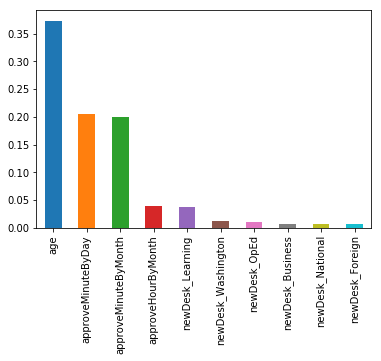

In [136]:
feature_importances = pd.Series(cont_model.feature_importances_, index = modelling_df.columns[modelling_df.var() > var_threshold]).sort_values(ascending = False)
feature_importances.head(10).plot.bar()

In [137]:
comments.columns

Index(['approveDate', 'articleID', 'commentBody', 'createDate', 'newDesk',
       'recommendations', 'typeOfMaterial', 'pubDate', 'age',
       'approveMinuteByDay', 'approveHourByMonth', 'approveMinuteByMonth',
       'approveHour', 'approveDay'],
      dtype='object')

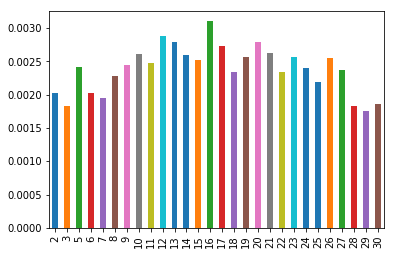

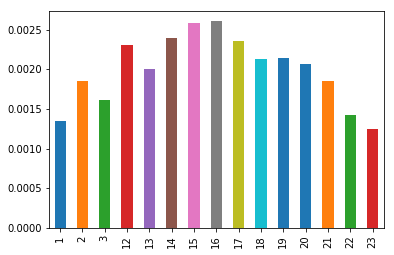

In [145]:
day_importances = feature_importances[feature_importances.index.str.contains('approveDay_')]
day_importances.index = day_importances.index.str.replace('approveDay_', '').astype(int)
day_importances.sort_index().plot.bar()

plt.figure()

hour_importances = feature_importances[feature_importances.index.str.contains('approveHour_')]
hour_importances.index = hour_importances.index.str.replace('approveHour_', '').astype(int)
hour_importances.sort_index().plot.bar()

# NLP Modelling

In [146]:
import pickle

combined_stop_words = ENGLISH_STOP_WORDS | {'http', 'https', 'br', 'www', 'href', 'com', 'target', '_blank'}
params = {'stop_words': combined_stop_words, 
          'ngram_range': (1, 3),
          'min_df': 100}

try:
    with open('text_binary_vectorizer.dat', 'rb') as f:
        binary_vec = pickle.load(f)
        print ('Trained binary vectorizer loaded successfully.')

except FileNotFoundError:
    binary_vec = TfidfVectorizer(binary = True, )
    print ('Training binary vectorizer from scratch...')
    binary_vec.fit(comments['commentBody'])
    print('Binary vectorizer successfully trained.')
    with open('text_binary_vectorizer.dat', 'wb') as f:
        pickle.dump(binary_vec, f)
        print('Binary vectorizer successfully saved.')
        
try:
    with open('text_total_vectorizer.dat', 'rb') as f:
        total_vec = pickle.load(f)
        print ('Trained total vectorizer loaded successfully.')

except FileNotFoundError:
    total_vec = TfidfVectorizer(stop_words = combined_stop_words, ngram_range = (1, 3), min_df = 50)
    print ('Training total vectorizer from scratch...')
    total_vec.fit(comments['commentBody'])
    print('Total vectorizer successfully trained.')
    with open('text_total_vectorizer.dat', 'wb') as f:
        pickle.dump(total_vec, f)
        print('Total vectorizer successfully saved.')

binary_text_vector = binary_vec.transform(comments['commentBody'])
total_text_vector = total_vec.transform(comments['commentBody'])
print ('Transformation complete.')

Trained binary vectorizer loaded successfully.
Trained total vectorizer loaded successfully.
Transformation complete.


In [195]:
text_model = BernoulliNB()
text_train_X = binary_text_vector[train_indices.values]
text_test_X = binary_text_vector[test_indices.values]
text_model.fit(text_train_X, train_y)
text_pred_y = text_model.predict(text_test_X)
text_model.score(text_test_X, test_y)
print(classification_report(test_y, text_pred_y))
pd.DataFrame(confusion_matrix(test_y, text_pred_y), index = ['true_{}'.format(i) for i in range(3)], columns = ['pred_{}'.format(j) for j in range(3)])

             precision    recall  f1-score   support

          0       0.36      0.52      0.43     56055
          1       0.51      0.37      0.43     93863
          2       0.33      0.34      0.33     46957

avg / total       0.42      0.40      0.40    196875



,pred_0,pred_1,pred_2
true_0,29286,17034,9735
true_1,36926,34434,22503
true_2,14435,16651,15871


In [156]:
word_importances = pd.DataFrame(np.e ** text_model.feature_log_prob_, columns = binary_vec.get_feature_names()).transpose()
word_importances.sort_values(by = 0, ascending = False).head(10)

,0,1,2
trump,0.248048,0.280777,0.290863
people,0.184515,0.183581,0.199945
like,0.168231,0.160124,0.171171
just,0.148882,0.152988,0.163150
don,0.108744,0.110418,0.120266
time,0.107886,0.110815,0.120549
think,0.106407,0.087098,0.092385
way,0.085863,0.084785,0.091428
good,0.084361,0.086336,0.089532
president,0.083403,0.093874,0.100588


In [196]:
text_model = MultinomialNB()
text_train_X = binary_text_vector[train_indices.values]
text_test_X = binary_text_vector[test_indices.values]
text_model.fit(text_train_X, train_y)
text_pred_y = text_model.predict(text_test_X)
text_model.score(text_test_X, test_y)
print(classification_report(test_y, text_pred_y))
pd.DataFrame(confusion_matrix(test_y, text_pred_y), index = ['true_{}'.format(i) for i in range(3)], columns = ['pred_{}'.format(j) for j in range(3)])

             precision    recall  f1-score   support

          0       0.52      0.13      0.20     56055
          1       0.49      0.94      0.64     93863
          2       0.49      0.03      0.05     46957

avg / total       0.50      0.49      0.38    196875



,pred_0,pred_1,pred_2
true_0,7058,48745,252
true_1,4499,88365,999
true_2,1901,43872,1184


In [165]:
(comments.loc[comments['commentBody'].str.contains('trump', case = False), 'recommendations'].value_counts() / comments.loc[comments['commentBody'].str.contains('trump', case = False), 'recommendations'].value_counts().sum()).sort_index()

0    0.257642
1    0.488714
2    0.253644
Name: recommendations, dtype: float64

In [166]:
(comments.loc[~comments['commentBody'].str.contains('trump', case = False), 'recommendations'].value_counts() / comments.loc[~comments['commentBody'].str.contains('trump', case = False), 'recommendations'].value_counts().sum()).sort_index()

0    0.294730
1    0.472391
2    0.232878
Name: recommendations, dtype: float64

In [149]:
cont_prob = pipeline.predict_proba(cont_test_X)
text_prob = text_model.predict_proba(text_test_X)

In [150]:
combined_pred_y = np.asarray(list(map(np.argmax, (cont_prob + text_prob) / 2)))
print(classification_report(test_y, combined_pred_y))
pd.DataFrame(confusion_matrix(test_y, combined_pred_y), index = ['true_{}'.format(i) for i in range(3)], columns = ['pred_{}'.format(j) for j in range(3)])

             precision    recall  f1-score   support

          0       0.53      0.57      0.55     56055
          1       0.61      0.58      0.59     93863
          2       0.48      0.48      0.48     46957

avg / total       0.56      0.55      0.55    196875



,pred_0,pred_1,pred_2
true_0,32155,18008,5892
true_1,21227,54359,18277
true_2,6931,17443,22583


In [192]:
from keras.models import Sequential

from keras.layers import Embedding, Dense, LSTM, Dropout

from keras import losses
from keras import metrics

from keras.utils import to_categorical

model = Sequential()

model.add(Dense(64, activation = 'relu', input_shape = (55016,)))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(3, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [193]:
model.fit(text_train_X, to_categorical(train_y), validation_data = (text_test_X, to_categorical(test_y)), epochs = 1)

Train on 459375 samples, validate on 196875 samples
Epoch 1/1
459375/459375 [==============================] - 281s 612us/step - loss: 1.0289 - acc: 0.4876 - val_loss: 1.0173 - val_acc: 0.4910
